<p style="font-size:36px;text-align:center"> <b>Malaria Bounding Boxes</b> </p>

### Final Notebook

In [0]:
#Mouning Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from os import path
from tqdm import tqdm
import tensorflow.python.keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.python.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Mean Average Precision

In [0]:
def map_value(annotate_path, result_df_path):
	"""
		This Function takes annotations file path and path of result dataframe which genereates after ecaluating test images
	"""

	def get_data(input_path):
		"""
			This Function takes annotations file path and gives a dictionory of ground truth labels and bounding boxes coordinates
		
		"""

		img_data = []
		
		with open(input_path,'r') as f:
			for line in f:
				line_split = line.strip().split(',')
				(filename,x1,y1,x2,y2,class_name) = line_split	

				img_data.append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})
			
		return img_data
	def union(au, bu, area_intersection):
		"""
			This function gives the area of union for intersection over union calculation
		"""
		area_a = (au[2] - au[0]) * (au[3] - au[1])
		area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
		area_union = area_a + area_b - area_intersection
		return area_union


	def intersection(ai, bi):
		"""
			This function gives the area of intersection for intersection over union calculation

		"""
		x = max(ai[0], bi[0])
		y = max(ai[1], bi[1])
		w = min(ai[2], bi[2]) - x
		h = min(ai[3], bi[3]) - y
		if w < 0 or h < 0:
			return 0
		return w*h

	def iou(a, b):
		# a and b should be (x1,y1,x2,y2)
		"""
			This function takes two boxes cordinates(ground truth and predicted) and gives intersection over union of 2 boxes

		"""

		if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
			return 0.0

		area_i = intersection(a, b)
		area_u = union(a, b, area_i)

		return float(area_i) / float(area_u + 1e-6)
	
	gt = get_data(annotate_path)
	pred = pd.read_csv(result_df_path)
	pred.columns = ["name", "class", "x1","y1","x2","y2", "prob"]
	Truth = {}
	Predicted = {}


	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array(pred["prob"])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]
	# we compare each predicted bounding box with ground truth bounding box
	for box_idx in tqdm(box_idx_sorted_by_prob):
		pred_box = pred.loc[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in Predicted:
			Predicted[pred_class] = []
			Truth[pred_class] = []
		Predicted[pred_class].append(pred_prob)
		found_match = False
		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']
			gt_x2 = gt_box['x2']
			gt_y1 = gt_box['y1']
			gt_y2 = gt_box['y2']
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou1 = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
	 # taking 0.5 as threshold i.e. if iou is greater than 0.5 then only it will consider as correct matching
			if iou1 >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue
		

		Truth[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:
			if gt_box['class'] not in Predicted:
				Predicted[gt_box['class']] = []
				Truth[gt_box['class']] = []

			Truth[gt_box['class']].append(1)
			Predicted[gt_box['class']].append(0)
	t = {}
	p = {}
	for key in Truth.keys():
			if key not in t:
				t[key] = []
				p[key] = []
			t[key].extend(Truth[key])
			p[key].extend(Predicted[key])
	
	all_aps = []
	for key in t.keys():
		ap = average_precision_score(t[key], p[key])
		print('{} AP: {}'.format(key, ap))
		all_aps.append(ap)
	print('mAP = {}'.format(np.mean(np.array(all_aps))))
	

### loading second level classifier best weights

In [0]:
def denseblock(input, num_filter = 12, dropout_rate = 0.5):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.SeparableConv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.5):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.SeparableConv2D(int(num_filter*compression), (7,7), use_bias=False,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output
num_filter = 64
batch_size = 32
num_classes = 6
epochs = 100
l = 10
compression = 0.45
dropout_rate = 0
input = layers.Input(shape=(32, 32, 3,))
First_Conv2D = layers.SeparableConv2D(num_filter, (5,5), use_bias=False, padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)
model = Model(inputs=[input], outputs=[output])
model.load_weights("/content/drive/My Drive/rcnn/second_classifier_checkpoint/epochs:030-val_acc:0.715.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Function to print images

In [0]:
 def predicted(image_name):

   """
   This function takes imag name and prints original image, predicted images of first lavel classifier and second level classifier

   """
  #print("Original Image with ground truth bounding boxes and labels")

   fig = plt.figure(figsize=(12,6))
   ax = fig.add_axes([0,0,1,1])
   ax.set_title("Original Image with ground truth bounding boxes and labels")

  # read and plot the image
   image = plt.imread('/content/drive/My Drive/rcnn/test_images/'+image_name)
   plt.imshow(image)
   edgecolor = 'r'
   test_df = pd.read_csv("/content/drive/My Drive/rcnn/test_df.csv")
  # iterating over the image for different objects
   for _,row in test_df[test_df["image"]=="/images/"+image_name].iterrows():
       xmin = row.x_min
       #print(xmin)
       xmax = row.x_max
       ymin = row.y_min
       ymax = row.y_max
       width = xmax - xmin
       height = ymax - ymin
      # assign different color to different classes of objects
       if row.class_label == 'red blood cell':
           edgecolor = 'r'
        
           ax.annotate('RBC', xy=(xmax-40,ymin+20))

       elif row.class_label == 'trophozoite':
           edgecolor = 'b'
           ax.annotate('trophozoite', xy=(xmax-40,ymin+20))
       elif row.class_label == 'difficult':
           edgecolor = 'b'
           ax.annotate('difficult', xy=(xmax-40,ymin+20))
       elif row.class_label == 'ring':
           edgecolor = 'b'
           ax.annotate('ring', xy=(xmax-40,ymin+20))
       elif row.class_label == 'schizont':
           edgecolor = 'b'
           ax.annotate('schizont', xy=(xmax-40,ymin+20))
       elif row.class_label == 'gametocyte':
           edgecolor = 'b'
           ax.annotate('gametocyte', xy=(xmax-40,ymin+20))
       elif row.class_label == 'leukocyte':
           edgecolor = 'b'
           ax.annotate('leukocyte', xy=(xmax-40,ymin+20))
          
      # add bounding boxes to the image
       rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
      
       ax.add_patch(rect)
    
   #print("Prediction after first classifier(which classifies RBC and OTHER)")
   fig = plt.figure(figsize=(12,6))
   ax = fig.add_axes([0,0,1,1])
   ax.set_title("Prediction after first classifier(which classifies RBC and OTHER)")

   # read and plot the image
   image = plt.imread('/content/drive/My Drive/rcnn/test_images/' + image_name)
   plt.imshow(image)
   result_df_2class = pd.read_csv("/content/drive/My Drive/rcnn/Data_model_2/result_df_2class.csv")


  # iterating over the image for different objects
   for _,row in result_df_2class.loc[result_df_2class["name"]==image_name].iterrows():
       xmin = row.x1
       #print(xmin)
       xmax = row.x2
       ymin = row.y1
       ymax = row.y2
      
       width = xmax - xmin
       height = ymax - ymin
       # assign different color to different classes of objects
       if row.label == 'other':
           edgecolor = 'b'
           ax.annotate('other', xy=(xmax-40,ymin+20))
          
       elif row.label == 'RBC':
           edgecolor = 'r'
           ax.annotate('RBC', xy=(xmax-40,ymin+20))
          
       # add bounding boxes to the image
      
       rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
       ax.add_patch(rect)
   testing_image = result_df_2class[result_df_2class["label"]=="other"][result_df_2class["name"]==image_name]
   testing_image.reset_index(inplace=True)
   if (testing_image.shape[0] != 0):
  
     import cv2
     from tqdm import tqdm
     testing_img_arrays = [] 
     y = []
     WIDTH = 32
     HEIGHT = 32

     for i in range(testing_image.shape[0]):
       image = plt.imread('/content/drive/My Drive/rcnn/test_images/'+image_name)
       image_crop = image[testing_image["y1"][i]:testing_image["y2"][i],testing_image["x1"][i]:testing_image["x2"][i]]
       testing_img_arrays.append(cv2.resize(image_crop, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
     testing_img_arrays_final = np.array(testing_img_arrays)
     model.load_weights("/content/drive/My Drive/rcnn/second_classifier_checkpoint/epochs:030-val_acc:0.715.hdf5")
     model_prediction = model.predict(testing_img_arrays_final)
     result_label = np.argmax(model_prediction, axis=1)
     feature_names = ['difficult', 'gametocyte', 'leukocyte', 'ring', 'schizont', 'trophozoite']
     fig = plt.figure(figsize=(12,6))
     ax = fig.add_axes([0,0,1,1])

    # read and plot the image
     image = plt.imread('/content/drive/My Drive/rcnn/test_images/'+image_name)
     plt.imshow(image)
     ax.set_title("prediction after second classifier(final prediction)")
     i=0

    # iterating over the image for different objects
     for _,row in result_df_2class[result_df_2class["name"]==image_name].iterrows():
         xmin = row.x1
         #print(xmin)
         xmax = row.x2
         ymin = row.y1
         ymax = row.y2
        
         width = xmax - xmin
         height = ymax - ymin
         # assign different color to different classes of objects
         if row.label == 'other':
             edgecolor = 'b'
             ax.annotate(feature_names[result_label[i]], xy=(xmax-40,ymin+20))
             i = i+1
         elif row.label == 'RBC':
             edgecolor = 'r'
             ax.annotate('RBC', xy=(xmax-40,ymin+20))
            
        # add bounding boxes to the image
         rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
        
         ax.add_patch(rect)

### Final Results

#### map of Test Data

In [0]:
print("MAP of test DATA:")
map_value("/content/drive/My Drive/rcnn/annotate_test_2class.txt","/content/drive/My Drive/rcnn/Data_model_2/result_df_2class.csv")

MAP of test DATA:


100%|██████████| 9195/9195 [01:22<00:00, 111.75it/s]

other AP: 0.960051090010949
RBC AP: 0.998090609353597
mAP = 0.979070849682273


#### Image Predictions

* sample_image:1
 ***Image with more nubmer of cells***

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


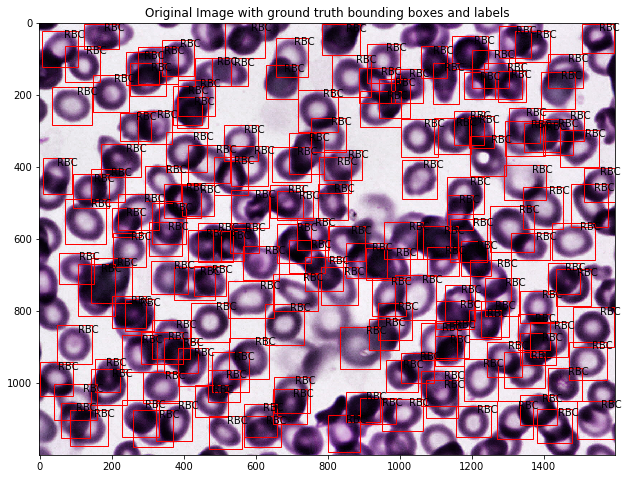

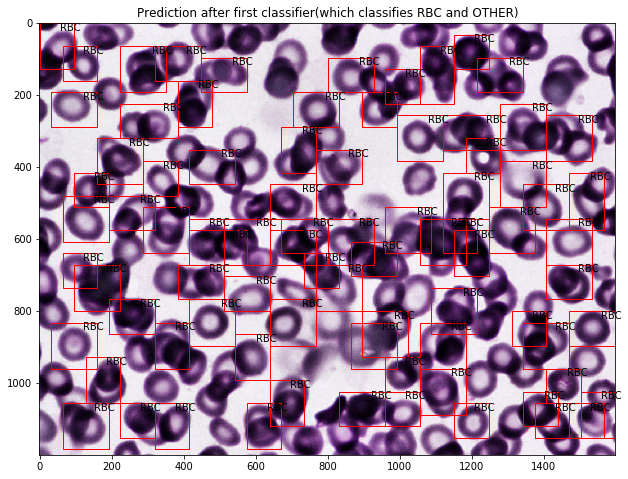

In [0]:
predicted("46a2d369-4bea-4405-ac78-91bbe130b9a7.png")

* sample_image:2
 ***Image with very few cells***

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


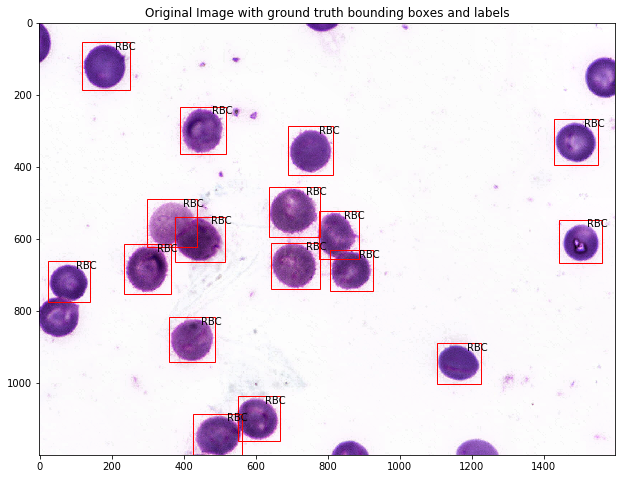

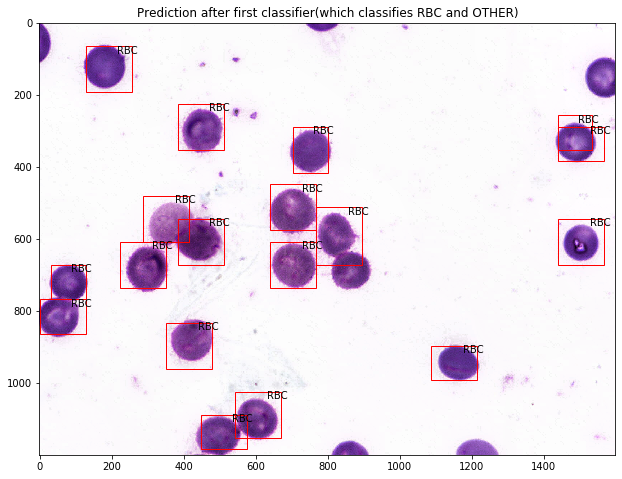

In [0]:
predicted("c3209548-7f7c-4afd-b47c-b42a72b1ebf7.png")

* sample_image:3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


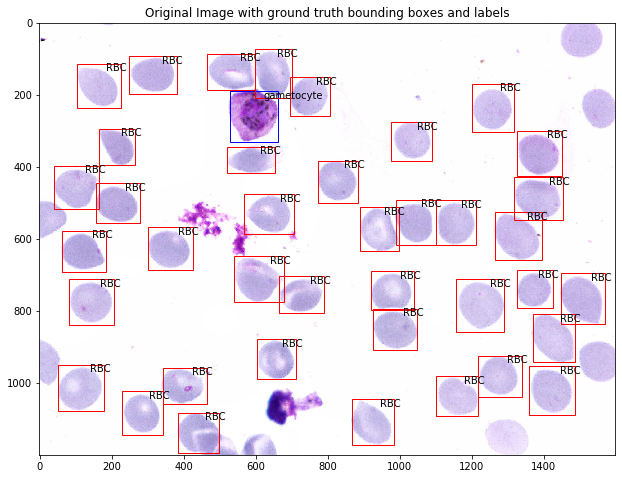

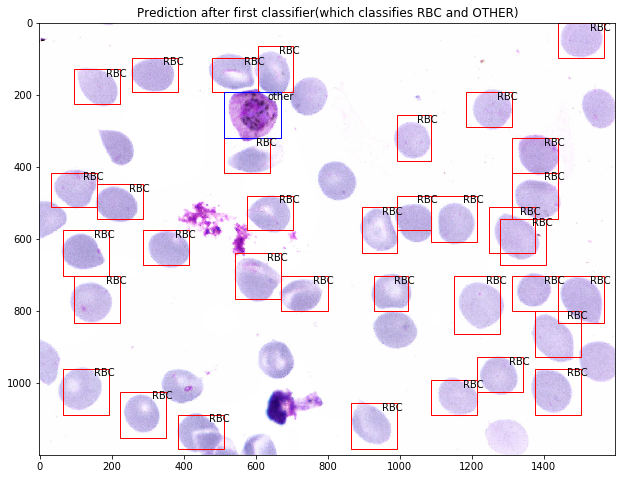

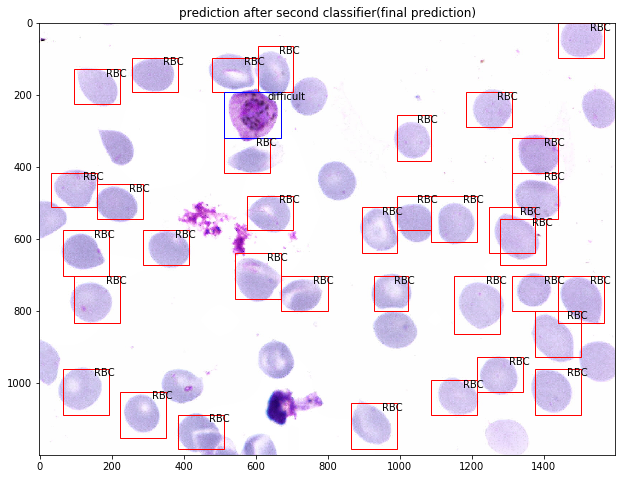

In [0]:
predicted("04de27ff-0d36-4da3-a829-e93851d76981.png")


* First level classifier predicting correctly and in this image we have "gametocyte" but our model is predicting as difficult, but difficult class consists of the cells which are difficult to classify. So if our model predict class as difficult we have to manually classify the cell.

---




* sample_image:4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


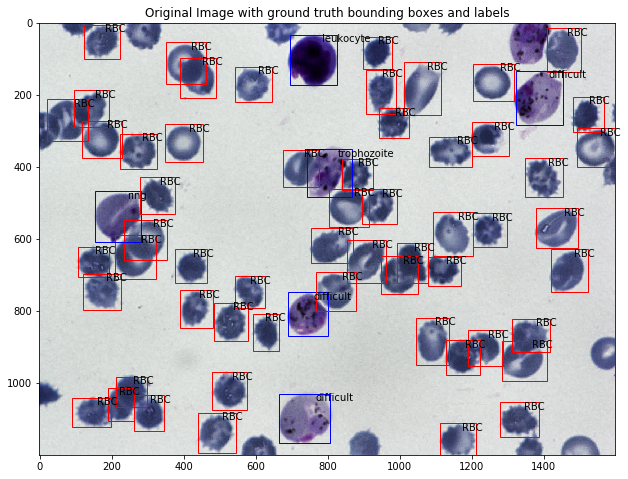

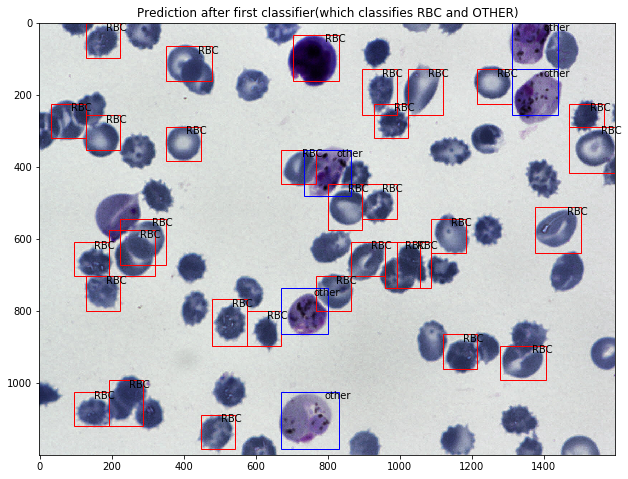

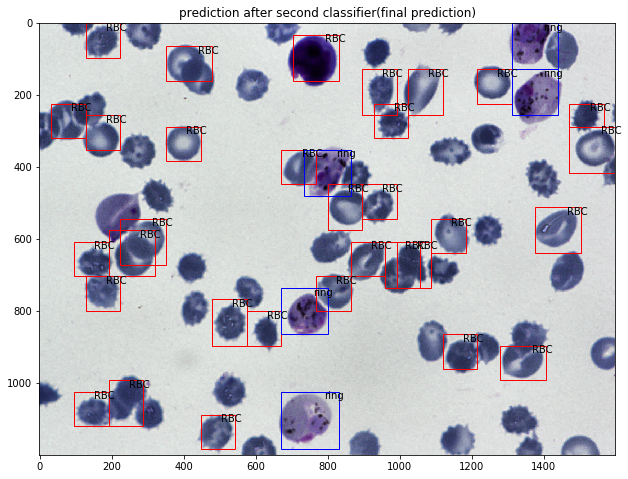

In [0]:
predicted("be6fe358-dee1-4dcf-9b0d-5d8612aba577.png")

* in the Actual image we have class difficult but our model predict them as ring. This may be correct prediction.
* Model could not able to predict the uninfected cell "Leuckocyte". This is the failure of first level classifier.

* sample_image:5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


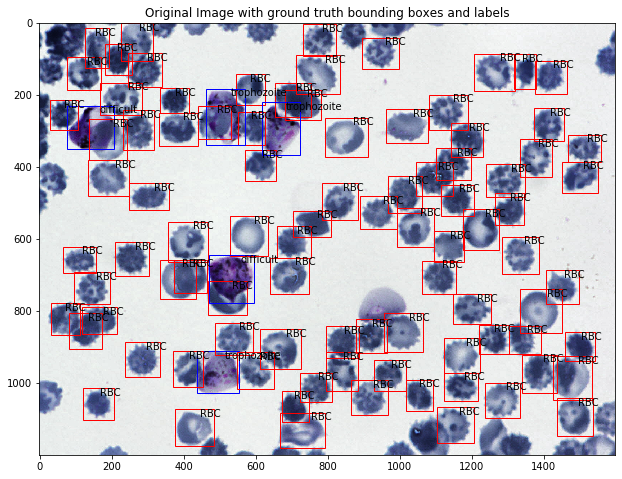

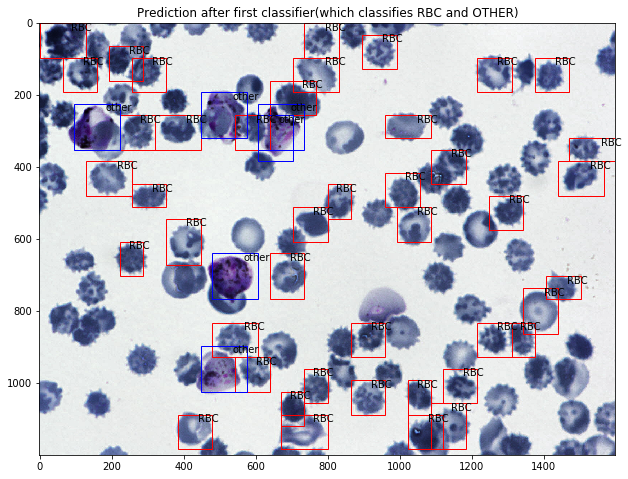

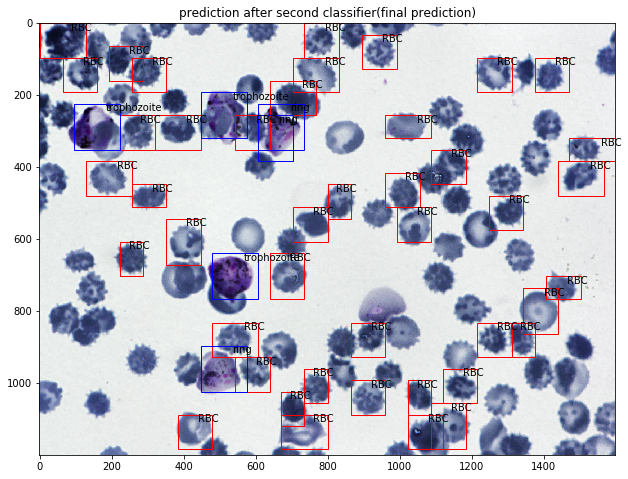

In [17]:
predicted("11b72c7b-5c52-44b7-adb7-21eacc25e441.png")

<h2> Conclusion </h2>

* Our First level Classifier is doing decent job in classifying the infected and and uninfected cells but not so well in classifying uninfected cells(RBC and Lueckocyte)
* Our second level classifier also working nice but i have taken very less resolution of cropped images due to memory issues. If we take good resolution we can get still more good results.
* our model is slightly confusing with "difficult" class, since actually it is not an infected cell type,it is just given because we could not able to classify few cells into  any of 6 categories. So our model will predict correct class instead of difficult.

<h2> Future Work </h2>

* Instead of taking two different classifiers, we could balance the dataset by creating duplicate images of minor class for example we can use GAN(Generative Adversarial Network) as a data augmentation technique.